get data from local database 

successfully connected to database
          ain situszip usecodedescchar1 sqftmain roll_landvalue  \
0  6079023009                Commercial        0        1656272   
1  5378020023                Commercial        0           5652   
2  5006006008                Commercial        0           1085   
3  8178001040                Commercial        0           9955   
4  6024009001                Commercial        0           3155   

  roll_landbaseyear istaxableparcel   center_lat     center_lon  
0              2011               Y                              
1              1975               Y  34.13765976  -118.07028189  
2              2007               Y  33.99332974  -118.33164086  
3              1997               Y  33.97044155  -118.07249959  
4              1986               Y  33.97138846  -118.25606768  
# of parcels updated in 2020:  234
# of parcels updated in 2021:  59
total # of parcels in table:  65761


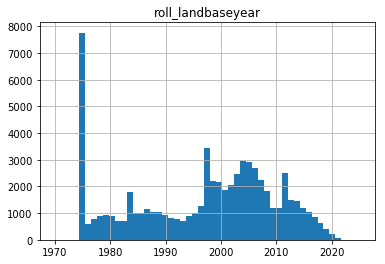

In [4]:
import pandas as pd
import psycopg2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# read data from local psql database into pd dataframe
try:
    conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
        "USER"), password=os.getenv("PASSWORD"))
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "rawparceltable"', con=conn)

print(df.head())

# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "usecode", "taxratearea", 
                "center_lat", "cluster", "situszip5",
                "center_lon", "roll_landvalue", "sqftmain"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

drop_cols = ['istaxableparcel', 'usecodedescchar1', 'usecodedescchar2']
df = df.drop(drop_cols, 1)

# some basic visuals on distr of the land base year
df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))


based on this reference: https://www.kaggle.com/gauthampughazh/house-sales-price-prediction-svr/notebook

In [5]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from IPython.display import FileLink


ModuleNotFoundError: No module named 'sklearn.impute'

In [ ]:

# split data into test and train
train_df, test_df = train_test_split(df, test_size=0.2)

# get correlation matrix
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()
